In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas

In [101]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Dropout, LSTM
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Configuration of Neural Network

In [3]:
# Convolutional Layer 1
filter_size1 = 5  # Convolution filters are 5 x 5 pixels.
num_filters1 = 16 # There are 16 of these filters

# Convolutional Layer 2
filter_size2 = 5  # Convolution filters are 5 x 5 pixels.
num_filters2 = 36 # There are 36 of these filters

# Fully-connected Layer
fc_size = 128     # Number of neurons in fully-connected layer.

# Load Data

(23000, 516, 388)


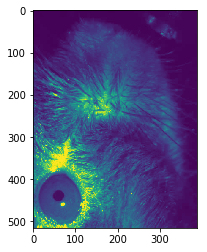

In [42]:
#open files, they have not been normalized yet
v = np.load("r4m7170321s1AVI.npy")
#(22796,516,388)
imc = plt.imshow((v[0]))
print(v.shape)
# dffile = v
dyfile = open('r4m7170321s1.pkl', "rb")
df = v
dy = pickle.load(dyfile)

(30000, 516, 388)
(22687, 22360)


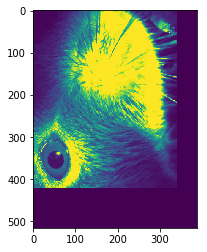

In [83]:
#dataset1
#open files, they have not been normalized yet
v = np.load("r3m1170210s2AVI.npy")

imc = plt.imshow((v[0]))
print(v.shape)
# dffile = v
dyfile = open('r3m1170210s2.pkl', "rb")
df = v
dy = pickle.load(dyfile)
print(dy.shape)

In [84]:
#dataset1
x_data = df[33:-7280]
print(np.sum(x_data[-1]))
print(len(x_data))

18043849.0
22687


In [43]:
#dataset2
x_data = df[49:-226]

In [85]:
num_data = len(x_data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val
x_train = x_data[0:num_train].reshape(num_train, (516*388))
x_val = x_data[num_train:(num_train+num_val)].reshape(num_val, (516*388))
x_test = x_data[(num_train+num_val):].reshape(num_test, (516*388))
y_train = dy[0:num_train].reshape(num_train, (172*130))
y_val = dy[num_train:(num_train+num_val)].reshape(num_val, (172*130))
y_test = dy[(num_train+num_val):].reshape(num_test, (172*130))

In [86]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [87]:
x_test_scaled = x_scaler.transform(x_test)
x_val_scaled = x_scaler.transform(x_val)

In [88]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
y_val_scaled = y_scaler.transform(y_val)

In [89]:
num_x_signals = x_train.shape[1]
print(num_x_signals)
num_y_signals = dy.shape[1]
print(num_y_signals)

200208
22360


In [49]:
# The number of pixels in each dimension of an image.
img_size_x = 516
img_size_y = 388

# The images are stored in one-dimensional arrays of this length.
img_size_flat = (516*388)

# Tuple with height and width of images used to reshape arrays.
img_shape = (516,388)

# I dont think I have this
# Number of classes, one class for each of 10 digits.
num_classes = 172*130

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1


In [50]:
#TODO comeback and make this useful for my data
def plot_images(images, cls_pred=None):
    
    #Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape(img_shape))
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

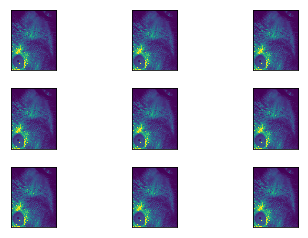

In [51]:
images = x_test[118:127]
plot_images(images=images)

## Helpter-Functions

In [161]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, 516, 388)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        if (idx+batch_size) >len(x_train_scaled):
            idx = idx-batch_size
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx].reshape(516,388)
            y_batch[i] = y_train_scaled[idx]
        
        yield (x_batch, y_batch)

In [137]:
batch_size = 100
channel_length = 1 #20 frames after stim time

In [138]:
generator = batch_generator(batch_size=batch_size, sequence_length=channel_length)

In [139]:
x_batch, y_batch = next(generator)

1534


In [140]:
print(x_batch.shape)
print(y_batch.shape)

(100, 516, 388)
(100, 22360)


In [126]:
x_test_scaled = x_test_scaled.reshape(num_test, 516, 388)
x_val_scaled = x_val_scaled.reshape(num_val, 516, 388)

In [127]:
validation_data = (x_val_scaled,
                  y_val_scaled)

In [151]:
model = Sequential()
model.add(Conv1D(100,
              kernel_size=5,
              strides=1,
              input_shape=(img_size_x, img_size_y)))
print(model.input_shape)

(None, 516, 388)


In [152]:
# model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(150, (5), activation='relu'))

model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_y_signals, activation='sigmoid'))

## Loss Function

In [153]:
optimizer = Adam(lr=1e-3)

In [154]:
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [155]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 512, 100)          194100    
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 508, 150)          75150     
_________________________________________________________________
lstm_4 (LSTM)                (None, 508, 150)          180600    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 169, 150)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 167, 128)          57728     
_________________________________________________________________
global_average_pooling1d_7 ( (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [156]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [157]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [158]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [159]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [160]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [162]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100
1006
3802
10216
4141
15142
15228
422
11760
7366
4333
6987
 99/100 [============================>.] - ETA: 1s - loss: 0.0168 - acc: 0.01358862

Epoch 00001: val_loss improved from inf to 0.03422, saving model to 23_checkpoint.keras
100/100 [==============================] - 165s 2s/step - loss: 0.0168 - acc: 0.0134 - val_loss: 0.0342 - val_acc: 0.0250
Epoch 2/100
5151
 86/100 [========================>.....] - ETA: 21s - loss: 0.0138 - acc: 0.021513879


 99/100 [============================>.] - ETA: 1s - loss: 0.0144 - acc: 0.0222611

Epoch 00002: val_loss did not improve from 0.03422

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 161s 2s/step - loss: 0.0144 - acc: 0.0226 - val_loss: 0.0367 - val_acc: 0.0250
Epoch 3/100
1735
 99/100 [============================>.] - ETA: 1s - loss: 0.0135 - acc: 0.030215456

Epoch 00003: val_loss improved from 0.03422 to 0.02776, saving model to 23_checkpoint.keras
100/100 [==============================] - 160s 2s/step - loss: 0.0135 - acc: 0.0301 - val_loss: 0.0278 - val_acc: 0.1029
Epoch 4/100
13374
 72/100 [====================>.........] - ETA: 43s - loss: 0.0164 - acc: 0.0357160


 99/100 [============================>.] - ETA: 1s - loss: 0.0165 - acc: 0.03818667

Epoch 00004: val_loss improved from 0.02776 to 0.02739, saving model to 23_checkpoint.keras
100/100 [==============================] - 160s 2s/step - loss: 0.0164 - acc: 0.0382 - val_loss: 0.0274 - val_acc: 0.1029
Epoch 5/100
13891
 99/100 [============================>.] - ETA: 1s - loss: 0.0141 - acc: 0.030710249

Epoch 00005: val_loss did not improve from 0.02739

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 160s 2s/step - loss: 0.0141 - acc: 0.0309 - val_loss: 0.0296 - val_acc: 0.0250
Epoch 6/100
1950
 58/100 [================>.............] - ETA: 1:05 - loss: 0.0128 - acc: 0.037910209


 99/100 [============================>.] - ETA: 1s - loss: 0.0133 - acc: 0.03856300

Epoch 00006: val_loss did not improve from 0.02739
100/100 [==============================] - 161s 2s/step - loss: 0.0136 - acc: 0.0381 - val_loss: 0.0282 - val_acc: 0.1029
Epoch 7/100
10928
 99/100 [============================>.] - ETA: 1s - loss: 0.0142 - acc: 0.034814477

Epoch 00007: val_loss did not improve from 0.02739
100/100 [==============================] - 163s 2s/step - loss: 0.0141 - acc: 0.0354 - val_loss: 0.0287 - val_acc: 0.1029
Epoch 8/100
1208
 46/100 [============>.................] - ETA: 1:22 - loss: 0.0126 - acc: 0.03399765


 99/100 [============================>.] - ETA: 1s - loss: 0.0127 - acc: 0.033914860

Epoch 00008: val_loss did not improve from 0.02739
100/100 [==============================] - 159s 2s/step - loss: 0.0126 - acc: 0.0343 - val_loss: 0.0275 - val_acc: 0.1029
Epoch 9/100
10186
 99/100 [============================>.] - ETA: 1s - loss: 0.0132 - acc: 0.036241

Epoch 00009: val_loss did not improve from 0.02739
100/100 [==============================] - 162s 2s/step - loss: 0.0132 - acc: 0.0358 - val_loss: 0.0278 - val_acc: 0.1029
Epoch 00009: early stopping
CPU times: user 38min 31s, sys: 8min, total: 46min 32s
Wall time: 24min 11s


In [93]:
result = model.evaluate(x_test_scaled,
                        y_test_scaled)


6127/6127 [==============================] - 14s 2ms/step


In [94]:
print(result)

[0.05428531101258949, 0.0]


In [70]:
model.save("DRPCNNds1.h5")

In [71]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [72]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [73]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]

        # Get the associated labels.
        labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Helper-function for plotting convolutional weights

In [74]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [75]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## plotting input images

In [76]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

In [80]:
def r2_keras(y_true, y_pred):
    SS_res =  np.sum(np.square(np.subtract(y_true,y_pred))) 
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true)))) 
    return ( 1 - SS_res/(SS_tot))

In [97]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled.reshape(num_train,516,388)
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled.reshape(num_test,516,388)
        y_true = y_test_scaled 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Use the model to predict the output-signals.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
#     x = np.expand_dims(x, axis=3)
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
#     of the original data-set.
#     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    sum_pred = []
    sum_true = []
 
    # For each output-signal.
    for i in range(len(x)):
        sum_pred.append(np.sum(y_pred[i])/(172*130))
        sum_true.append(np.sum(y_true[i])/(172*130))
    # Plot and compare the two signals.
    plt.plot(sum_true[:1200], label='true')
    plt.plot(sum_pred[:1200], label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred))
    print(explained_variance_score(y_true, y_pred,multioutput='uniform_average'))
    # Plot grey box for warmup-period.


    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

r2
0.05449879169464111
-1.1483722488014345e-05


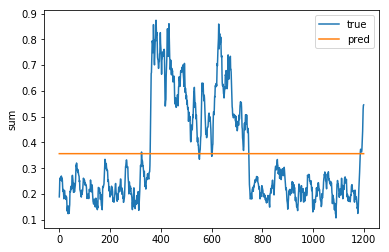

In [163]:
plot_comparison(start_idx=1, length=num_test, train=False)

In [35]:
image1 = x_test[0]
plot_image(image1)

NameError: name 'plot_image' is not defined

In [51]:
def plot_image_difference(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled.reshape(num_train,516,388)
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled.reshape(num_test,516,388)
        y_true = y_test_scaled 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Use the model to predict the output-signals.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
#     x = np.expand_dims(x, axis=3)
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
#     of the original data-set.
#     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    plt.figure(figsize=(15,5))
    imc = plt.imshow((np.subtract(y_true[4], y_pred[4])).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='difference')
    print("r2")
    print(explained_variance_score(y_true, y_pred))

    plt.legend()
    plt.show()
    plt.figure(figsize=(15,5))
    imc = plt.imshow((y_pred[4]).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='pred')


    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    imc = plt.imshow((y_true[4]).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='true')


    plt.legend()
    plt.show()

No handles with labels found to put in legend.


r2
0.2839682710138758


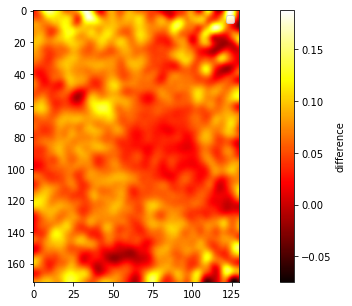

No handles with labels found to put in legend.


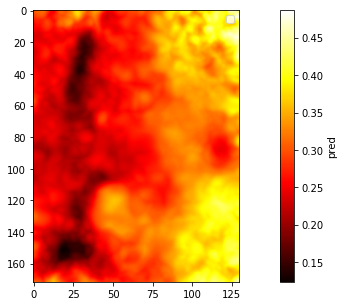

No handles with labels found to put in legend.


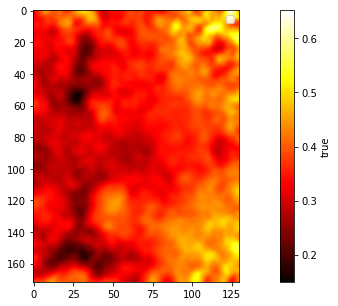

In [52]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()
plot_image_difference(start_idx=1, length=40, train=False)